# Fine Tuning DistilBERT, BERT for Fake News Detection

## Import Library

In [1]:
!pip install -U datasets

import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system

In [ ]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Transformers and Tokenization
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, Trainer

# PyTorch
import torch

# Dataset Handling
from datasets import Dataset, DatasetDict

# Time Measurement
import time

In [2]:
  df = pd.read_excel("https://github.com/Syahmi33github/Porto_AI_Streamlit/raw/main/fine_tuning_distilbert_mobilebert_and_tinybert_fake_news_detection/fake_news.xlsx")

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [4]:
df.isnull().sum()
df = df.dropna()

df.isnull().sum()

,0
id,0
title,0
author,0
text,0
label,0


## Dataset Analysis

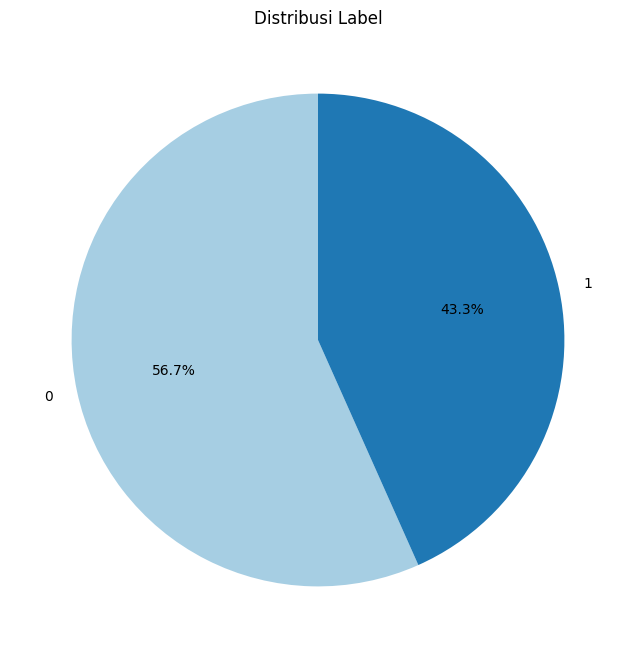

In [5]:
# Hitung frekuensi dari setiap label
label_counts = df['label'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Distribusi Label')
plt.show()

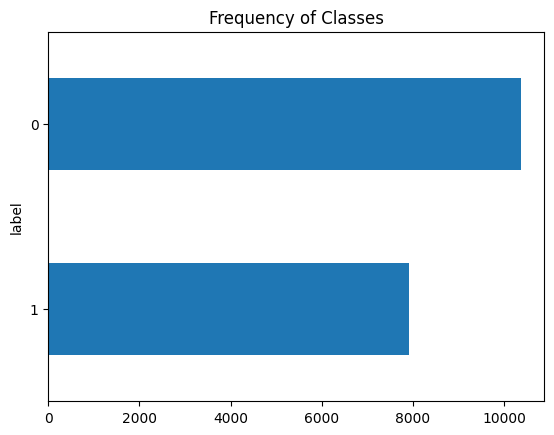

In [6]:
label_counts = df['label'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

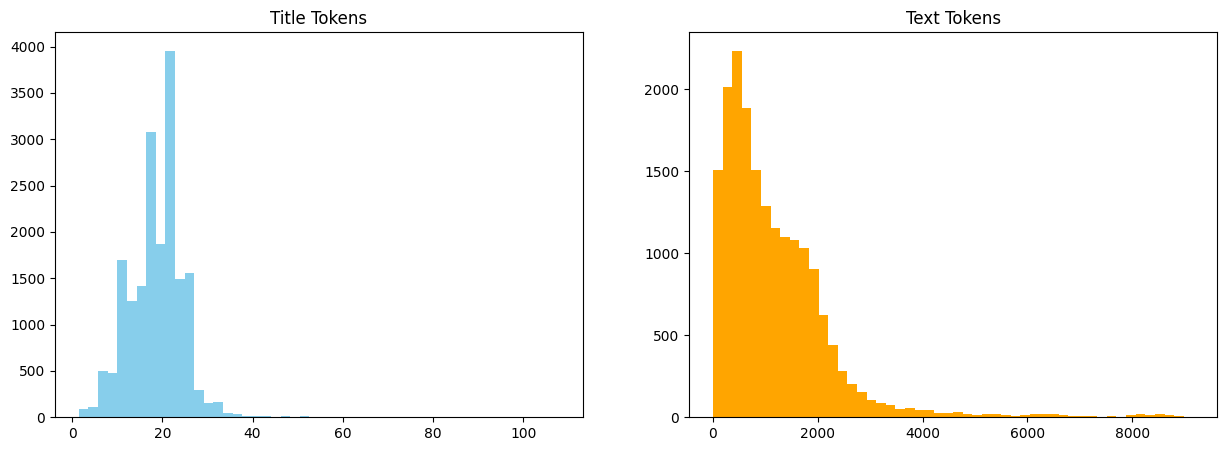

In [7]:
# 1.5 tokens per word on average
df['title_tokens'] = df['title'].apply(lambda x: len(x.split())*1.5)
df['text_tokens'] = df['text'].apply(lambda x: len(x.split())*1.5)


fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].hist(df['title_tokens'], bins=50, color = 'skyblue')
ax[0].set_title("Title Tokens")

ax[1].hist(df['text_tokens'], bins=50, color = 'orange')
ax[1].set_title("Text Tokens")

plt.show()

## Data Loader and Train Test Split

In [8]:
# 70% for training, 20% test, 10% validation
train, test = train_test_split(df, test_size=0.3, stratify=df['label'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label'])

train.shape, test.shape, validation.shape, df.shape

((12796, 7), (3656, 7), (1829, 7), (18281, 7))

In [9]:
dataset = DatasetDict(
    {
        "train": Dataset.from_pandas(train, preserve_index=False),
        "test": Dataset.from_pandas(test, preserve_index=False),
        "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 12796
    })
    test: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 3656
    })
    validation: Dataset({
        features: ['id', 'title', 'author', 'text', 'label', 'title_tokens', 'text_tokens'],
        num_rows: 1829
    })
})

## Model Fine-Tuning

## Benchmarking

In [18]:
label2id = {"Real": 0, "Fake": 1}
id2label = {0:"Real", 1:"Fake"}

num_labels = len(label2id)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# use sklearn to build compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)

    return {"accuracy": acc, "f1": f1}

In [22]:
model_dict = {
    "bert-base": "bert-base-uncased",
    "distilbert": "distilbert-base-uncased",
}

def train_model(model_name):
    model_ckpt = model_dict[model_name]
    tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
    config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config).to(device)

    def local_tokenizer(batch):
        temp = tokenizer(batch['title'], padding=True, truncation=True)
        return temp

    encoded_dataset = dataset.map(local_tokenizer, batched=True, batch_size=None)

    trainer = Trainer(
                model=model,
                compute_metrics=compute_metrics,
                train_dataset=encoded_dataset['train'],
                eval_dataset=encoded_dataset['validation'],
                tokenizer=tokenizer
            )

    import os
    os.environ["WANDB_DISABLED"] = "true"

    trainer.train()

    preds = trainer.predict(encoded_dataset['test'])

    # Set the save directory dynamically based on model name
    save_dir = f"saved_models/{model_name}"

    # Save the model and tokenizer to the specified directory
    model.save_pretrained(save_dir)
    tokenizer.save_pretrained(save_dir)

    return preds.metrics

model_performance = {}
for model_name in model_dict:
    print("\n\n")
    print("Training Model: ", model_name)

    start = time.time()
    result = train_model(model_name)
    end = time.time()

    model_performance[model_name] = {model_name:result, "time taken": end-start}




Training Model:  bert-base


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.247400
1000,0.187500
1500,0.183500
2000,0.107800
2500,0.091300
3000,0.096700
3500,0.045700
4000,0.035200
4500,0.025200





Training Model:  distilbert


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/12796 [00:00<?, ? examples/s]

Map:   0%|          | 0/3656 [00:00<?, ? examples/s]

Map:   0%|          | 0/1829 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
500,0.234200
1000,0.150400
1500,0.155900
2000,0.094400
2500,0.077700
3000,0.079200
3500,0.042100
4000,0.033000
4500,0.023900


In [23]:
model_performance

{'bert-base': {'bert-base': {'test_loss': 0.20327861607074738,
   'test_accuracy': 0.9644420131291028,
   'test_f1': 0.964439358382751,
   'test_runtime': 16.9722,
   'test_samples_per_second': 215.411,
   'test_steps_per_second': 26.926},
  'time taken': 895.3472330570221},
 'distilbert': {'distilbert': {'test_loss': 0.1831059753894806,
   'test_accuracy': 0.9647155361050328,
   'test_f1': 0.9646980140430079,
   'test_runtime': 9.1405,
   'test_samples_per_second': 399.979,
   'test_steps_per_second': 49.997},
  'time taken': 494.77710580825806}}

In [31]:
# Menyimpan hasil dalam list
results = []
for model, values in model_performance.items():
    metrics = values[model]
    results.append({
        'model': model,
        'test_accuracy': metrics['test_accuracy'],
        'test_f1': metrics['test_f1'],
        'testing_runtime': metrics['test_runtime'],
        'training_time': values['time taken']
    })

# Menampilkan hasil
for res in results:
    print(res)

{'model': 'bert-base', 'test_accuracy': 0.9644420131291028, 'test_f1': 0.964439358382751, 'testing_runtime': 16.9722, 'training_time': 895.3472330570221}
{'model': 'distilbert', 'test_accuracy': 0.9647155361050328, 'test_f1': 0.9646980140430079, 'testing_runtime': 9.1405, 'training_time': 494.77710580825806}


In [32]:
results

[{'model': 'bert-base',
  'test_accuracy': 0.9644420131291028,
  'test_f1': 0.964439358382751,
  'testing_runtime': 16.9722,
  'training_time': 895.3472330570221},
 {'model': 'distilbert',
  'test_accuracy': 0.9647155361050328,
  'test_f1': 0.9646980140430079,
  'testing_runtime': 9.1405,
  'training_time': 494.77710580825806}]

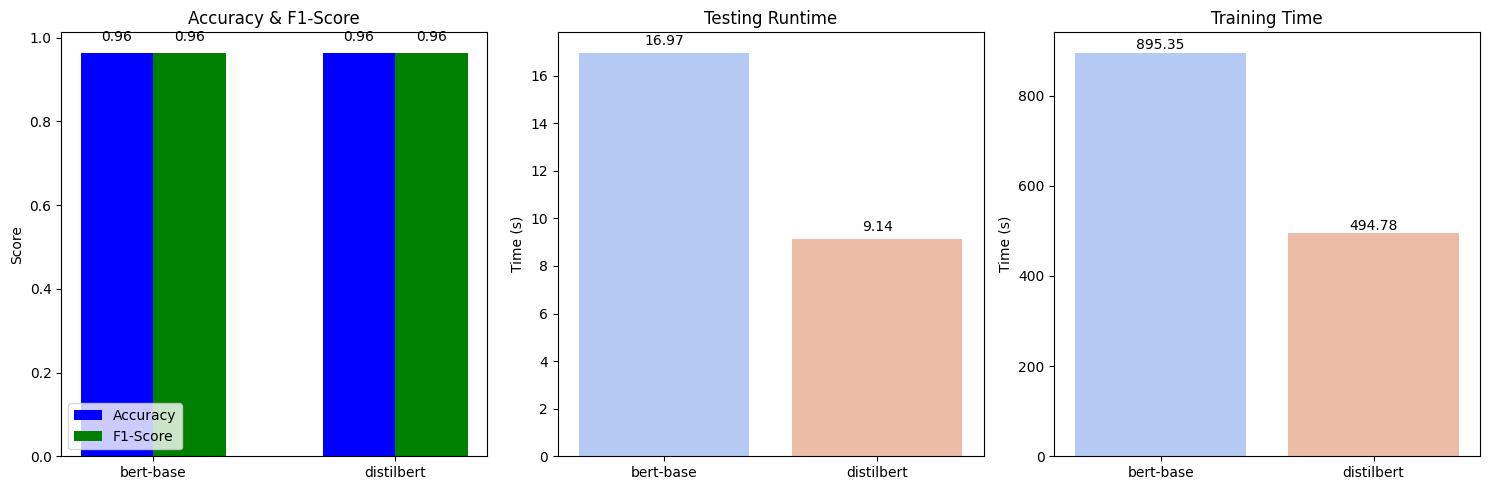

In [44]:
models = [d['model'] for d in results]
accuracy = [d['test_accuracy'] for d in results]
f1_scores = [d['test_f1'] for d in results]
testing_runtime = [d['testing_runtime'] for d in results]
training_time = [d['training_time'] for d in results]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Bar plot for Accuracy and F1-Score
x = np.arange(len(models))
width = 0.3
bars_acc = axes[0].bar(x - width/2, accuracy, width, label='Accuracy', color='blue')
bars_f1 = axes[0].bar(x + width/2, f1_scores, width, label='F1-Score', color='green')
axes[0].set_xticks(x)
axes[0].set_xticklabels(models)
axes[0].set_ylabel("Score")
axes[0].set_title("Accuracy & F1-Score")
axes[0].legend()

# Add values above bars for Accuracy and F1-Score
for bar in bars_acc:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')
for bar in bars_f1:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 2), ha='center', va='bottom')

# Bar plot for Testing Runtime
sns.barplot(x=models, y=testing_runtime, ax=axes[1], palette='coolwarm')
axes[1].set_ylabel("Time (s)")
axes[1].set_title("Testing Runtime")

# Add values above bars for Testing Runtime
for p in axes[1].patches:
    axes[1].text(p.get_x() + p.get_width()/2, p.get_height() + 0.2, round(p.get_height(), 2),
                 ha='center', va='bottom')

# Bar plot for Training Time
sns.barplot(x=models, y=training_time, ax=axes[2], palette='coolwarm')
axes[2].set_ylabel("Time (s)")
axes[2].set_title("Training Time")

# Add values above bars for Training Time
for p in axes[2].patches:
    axes[2].text(p.get_x() + p.get_width()/2, p.get_height() + 0.2, round(p.get_height(), 2),
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


## Download Model

## Gdrive

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
!zip -r /content/drive/MyDrive/fake_news_distilbert.zip /content/fake_news

  adding: content/fake_news/ (stored 0%)
  adding: content/fake_news/training_args.bin (deflated 52%)
  adding: content/fake_news/vocab.txt (deflated 53%)
  adding: content/fake_news/config.json (deflated 50%)
  adding: content/fake_news/tokenizer_config.json (deflated 75%)
  adding: content/fake_news/model.safetensors (deflated 7%)
  adding: content/fake_news/tokenizer.json (deflated 71%)
  adding: content/fake_news/special_tokens_map.json (deflated 42%)
